<a href="https://colab.research.google.com/github/KavinKarthik18/vehicle-movement-count-tracking-yolov8/blob/main/vehicle_traffic_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-" -O vehicle-counting.mp4 && rm -rf /tmp/cookies.txt

/content
--2024-03-26 03:37:43--  https://docs.google.com/uc?export=download&confirm=&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-
Resolving docs.google.com (docs.google.com)... 209.85.146.102, 209.85.146.101, 209.85.146.113, ...
Connecting to docs.google.com (docs.google.com)|209.85.146.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-&export=download [following]
--2024-03-26 03:37:43--  https://drive.usercontent.google.com/download?id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 64.233.183.132, 2607:f8b0:4001:c0b::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|64.233.183.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35345757 (34M) [video/mp4]
Saving to: ‘vehicle-counting.mp4’

vehicle-counting.mp 100%[===================>]  33.71M   194

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"

install yolov8

In [ ]:


!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.9/107.7 GB disk)


bytetrack installation


In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

load pre trained model

In [ ]:
MODEL = "yolov8x.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 141MB/s]


YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model=yolov8x.pt conf=0.25 source={SOURCE_VIDEO_PATH}

/content
100% 131M/131M [00:00<00:00, 165MB/s]
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs

video 1/1 (frame 1/538) /content/vehicle-counting.mp4: 384x640 3 cars, 1 truck, 4192.9ms
video 1/1 (frame 2/538) /content/vehicle-counting.mp4: 384x640 3 cars, 1 truck, 2939.8ms
video 1/1 (frame 3/538) /content/vehicle-counting.mp4: 384x640 4 cars, 2 trucks, 2873.1ms
video 1/1 (frame 4/538) /content/vehicle-counting.mp4: 384x640 5 cars, 1 truck, 2834.8ms
video 1/1 (frame 5/538) /content/vehicle-counting.mp4: 384x640 4 cars, 1 truck, 5435.2ms
video 1/1 (frame 6/538) /content/vehicle-counting.mp4: 384x640 4 cars, 1 truck, 2816.1ms
video 1/1 (frame 7/538) /content/vehicle-counting.mp4: 384x640 4 cars, 1 truck, 2839.6ms
video 1/1 (frame 8/538) /content/vehicle-counting.mp4: 384x640 5 cars, 1 truck, 2851.9ms
video 1/1 (frame 9/538) /content/vehicle-counting.mp4: 384x640 4 cars, 

predicting single frame

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]


0: 384x640 3 cars, 1 truck, 2873.2ms
Speed: 5.8ms preprocess, 2873.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


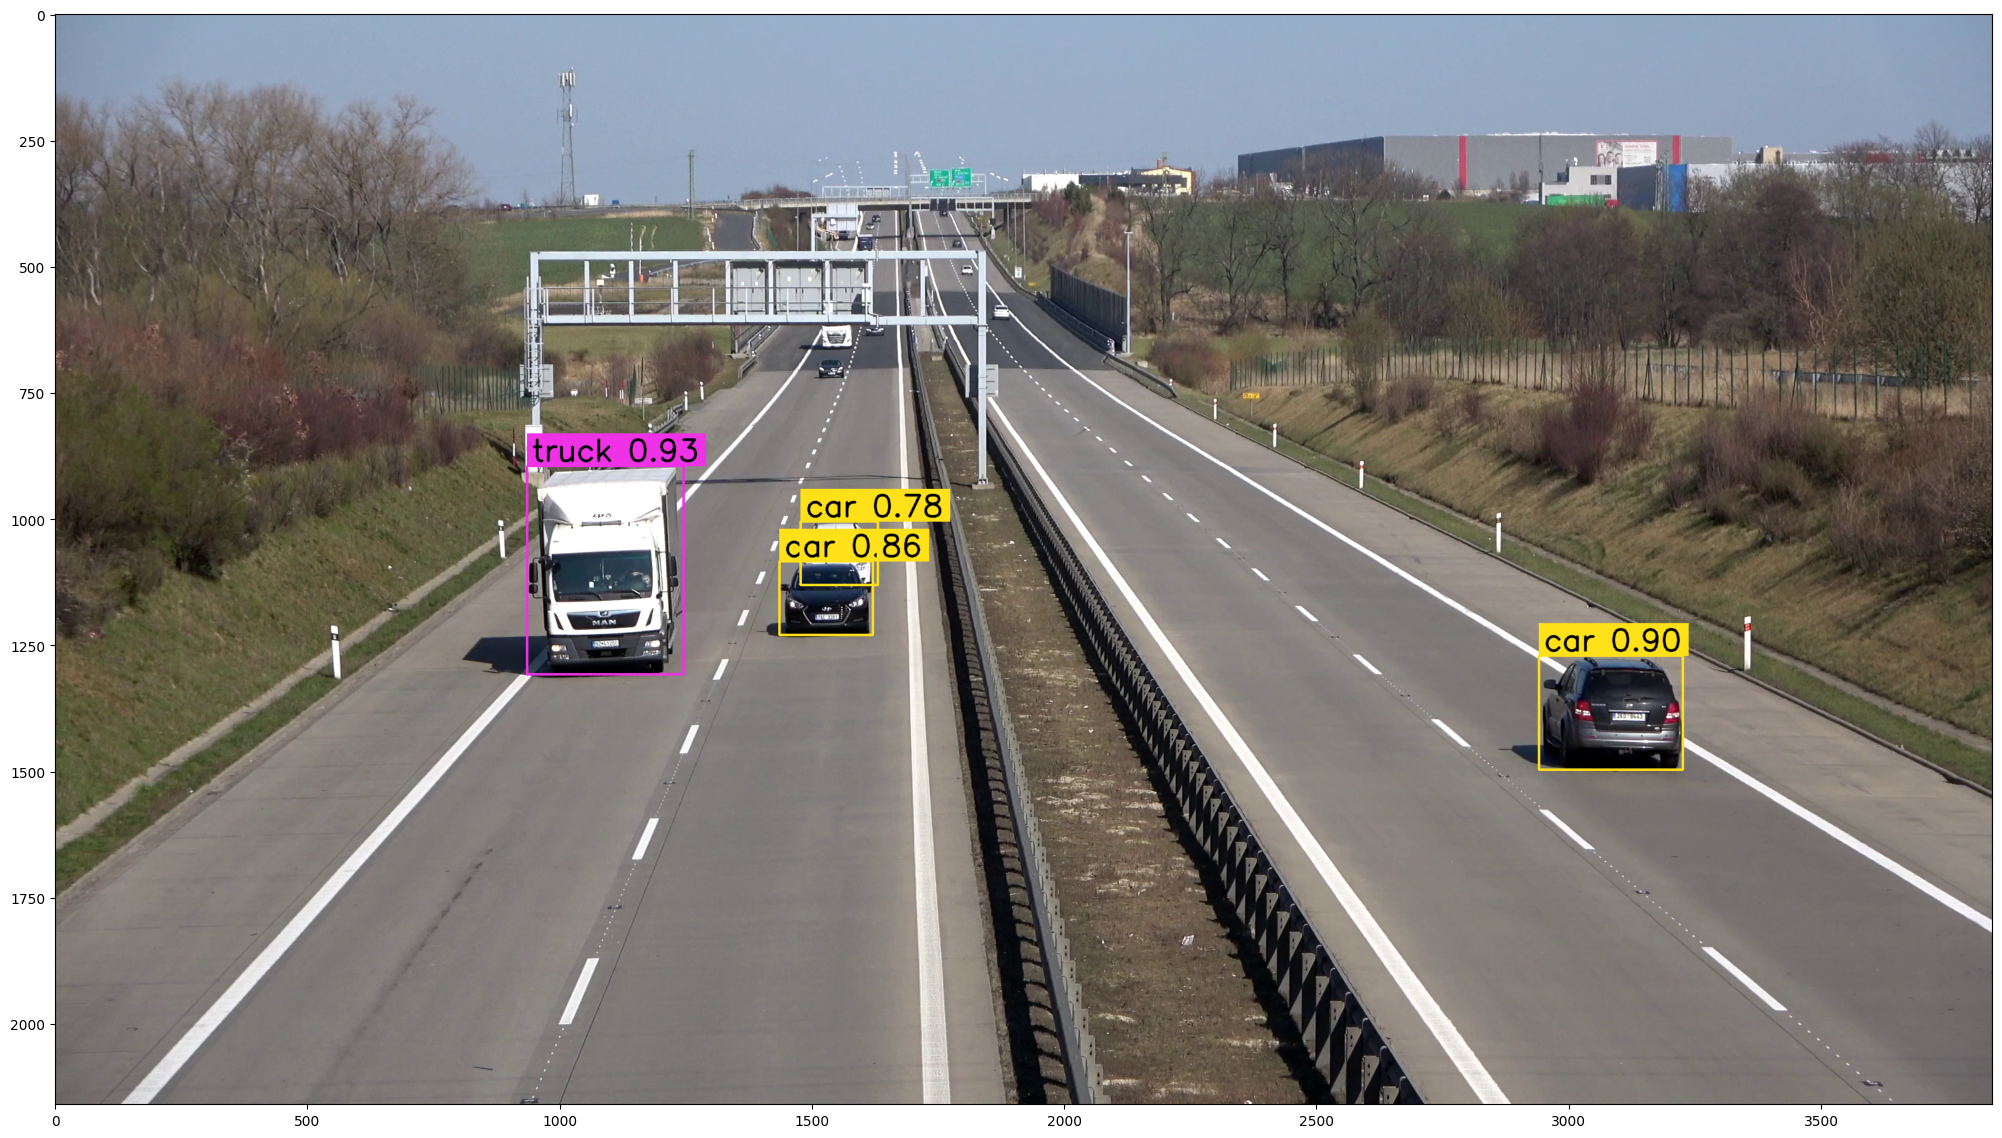

In [ ]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (25, 25))

annotate whole vid

In [ ]:
# settings
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result.mp4"

In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)